In [8]:
import pandas as pd
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Infant mortality rate (per 1000 live births                  -0.702155
Pop. using improved sanitation facilities (urban/rural, %)   -0.701874
Fertility rate, total (live births per woman)                -0.635398
Economy: Agriculture (% of GVA)                              -0.596738
Employment: Agriculture (% of employed)                      -0.579133
Name: Happiness, dtype: float64
Economy: Services and other activity (% of GVA)          0.580328
Urban population (% of total population)                 0.666212
Employment: Services (% of employed)                     0.709983
GDP per capita (current US$)                             0.729044
Mobile-cellular subscriptions (per 100 inhabitants).1    0.789833
Name: Happiness, dtype: float64


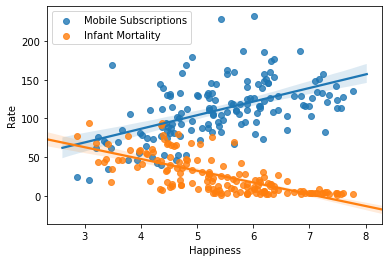

In [191]:
happiness = pd.read_csv('2019d.csv')
stats_toomany = pd.read_csv('country_statsd.csv')

keep_countries = [] # List of common countries
for i in stats_toomany.country:
    for j in happiness['Country or region']: # Search thru the happiness file
        if i==j:                             # and see if the country names match
            keep = keep_countries.append(i)  # if they do, add them to the common list

# Creating new dataframe with all columns of stats_toomany, 
# but only for countries that are also in the happiness dataset.

stats = stats_toomany[(stats_toomany['country'].isin(keep_countries))]

# Checking that datasets match.
stats.sort_values(by=['country'])
happiness.sort_values(by=['Country or region'])
stats.shape
happiness.shape
stats.head(5)

# Adding the happiness scores to the stats dataset.
stats.sort_values(by=['country'])
happiness.sort_values(by=['Country or region'])
stats['Happiness']=happiness['Score']
stats = stats.set_index('country')

stats.replace(to_replace='...', value =0, inplace=True) # Changing strings to numerics
stats.replace(to_replace='~0.0', value =0, inplace=True)
stats.replace(to_replace='-~0.0', value =0, inplace=True)
list_of_columns_ToBeFloats = stats.columns[3:]
for col in list_of_columns_ToBeFloats:
    stats[col] = stats[col].astype(float)
    
# Checking correlations between all numeric attributes
correlations = stats.corr()
correlations.sort_values(by=['Happiness'], inplace=True)
bottom5cor = correlations[:5]['Happiness']
print(bottom5cor)
top5cor = correlations[-6:-1]['Happiness']
print(top5cor)

# Plotting the two attributes that have the biggest effect on happiness.
# One most positive, and one most negative.
a=sns.regplot(x=stats['Happiness'], y=stats['Mobile-cellular subscriptions (per 100 inhabitants)'],label="Mobile Subscriptions");
a=sns.regplot(x=stats['Happiness'], y=stats['Infant mortality rate (per 1000 live births'], label="Infant Mortality");
a.set(ylabel="Rate")
a.legend()

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [531]:
# Creating a Multiple Linear Regression model to predict happiness score
X = stats.iloc[:, 1:-1]
Y = stats.iloc[:, -1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state= 111)

happiness_model = linear_model.LinearRegression()
happiness_model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

                          Real Value  Prediction Value
country                                               
Hong Kong                      5.430          6.299637
South Africa                   4.722          5.477215
Comoros                        3.973          3.831765
Latvia                         5.940          6.284237
Central African Republic       3.083          4.450132
Chad                           4.350          4.450640
Denmark                        7.600          7.028171
South Sudan                    2.853        442.901472


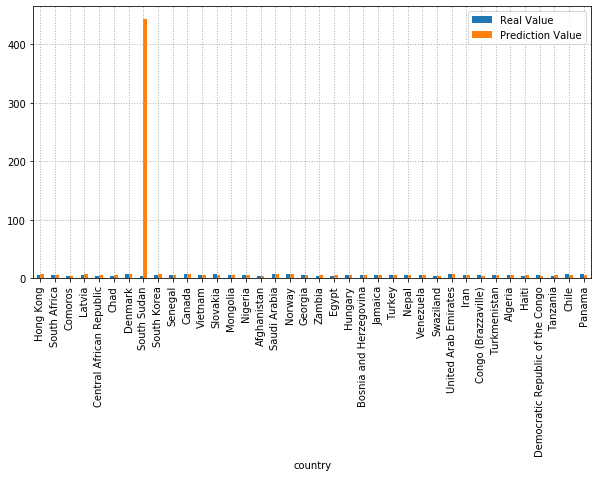

In [588]:
# predicting happiness score, and plotting against the real values
y_pred = happiness_model.predict(X_test)

checking_pred = pd.DataFrame({'Real Value': Y_test, 'Prediction Value': y_pred})
print(checking_pred.head(8))

checking_pred.plot(kind='bar', figsize=(10,5))
plt.grid(which='major', linestyle=':', linewidth='1')
plt.show()

In [587]:
# Remember how odd the South Sudan prediction is, and let's compare later with the last prediction we'll make about it.
# Besdies this one freak prediction, you can see that our predictions are really off in most countries.
# Checking the measures of how fit the model is, and how accurate the predictions are.
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))      
r2_value = r2_score(Y_test, y_pred)                     

print("Intercept: \t\t", happiness_model.intercept_)
print("Root Mean Square Error: ", rmse)
print("R^2 Value: \t\t", r2_value)

Intercept: 		 110.67266386289029
Root Mean Square Error:  71.38837700762701
R^2 Value: 		 -3617.9907298736966


In [560]:
# Shockingly (not),the predictions were very bad, and the model is a bad fit...
# Now let's try to make a model where the independent attributes are the top/bottom 5 correlations (from first code block).
X2 = stats.iloc[:, [26, -2, 24, 8, 11, 10, 22, 13, 7, 32]]
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y, random_state= 111)

happiness_model2 = linear_model.LinearRegression()
happiness_model2.fit(X2_train, Y2_train)

# checking the coefficients
coeff_corrs2 = pd.DataFrame(happiness_model2.coef_, index = X2.columns, columns=['Coefficient'])
print(coeff_corrs2)

                                                    Coefficient
Infant mortality rate (per 1000 live births            0.000676
Pop. using improved sanitation facilities (urba...    -0.002094
Fertility rate, total (live births per woman)         -0.094369
Economy: Agriculture (% of GVA)                        0.000858
Employment: Agriculture (% of employed)                0.006378
Economy: Services and other activity (% of GVA)       -0.000081
Urban population (% of total population)               0.003080
Employment: Services (% of employed)                   0.018159
GDP per capita (current US$)                           0.000015
Mobile-cellular subscriptions (per 100 inhabita...     0.009003


                          Real Value  Prediction Value
country                                               
Hong Kong                      5.430          7.025409
South Africa                   4.722          5.470586
Comoros                        3.973          4.439881
Latvia                         5.940          6.182011
Central African Republic       3.083          4.268366
Chad                           4.350          4.127884
Denmark                        7.600          7.106790
South Sudan                    2.853          0.997072


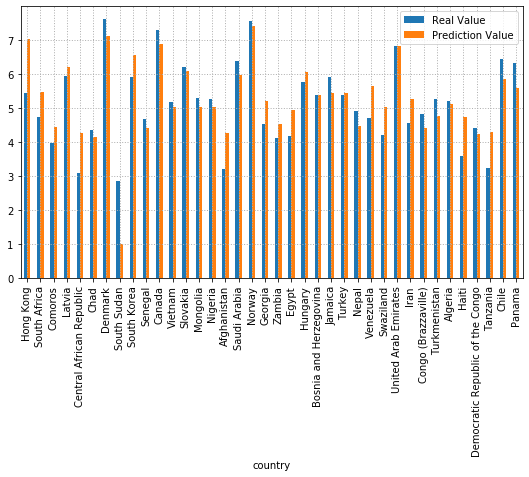

Intercept: 		 3.6721624428151136
Root Mean Square Error:  0.6925705828399503
R^2 Value: 		 0.6593875366207194


In [585]:
# plotting the prediction against the real values, and checking the measures of how fit the model is
y2_pred = happiness_model2.predict(X2_test)

checking_pred2 = pd.DataFrame({'Real Value': Y2_test, 'Prediction Value': y2_pred})
print(checking_pred2.head(8))

checking_pred2.plot(kind='bar', figsize=(9,5))
plt.grid(which='major', linestyle=':', linewidth='1')
plt.show()

rmse2 = np.sqrt(mean_squared_error(Y2_test, y2_pred))      
r2_value2 = r2_score(Y2_test, y2_pred)                     

print("Intercept: \t\t", happiness_model2.intercept_)
print("Root Mean Square Error: ", rmse2)
print("R^2 Value: \t\t", r2_value2)

In [580]:
# This model is on the way to be good! However, we can still do much better.
# Notice how the prediction for South Sudan is in the right range now, but still very far off the real value.
# Checking the Variance Inflation Factors before moving on to building another model.
vif_factor_2 = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif2 = pd.DataFrame(vif_factor_2, index = X2.columns, columns = ["VIF"])
print(vif2)

                                                          VIF
Infant mortality rate (per 1000 live births         16.225653
Pop. using improved sanitation facilities (urba...   4.418741
Fertility rate, total (live births per woman)       25.805331
Economy: Agriculture (% of GVA)                      6.306982
Employment: Agriculture (% of employed)              6.298871
Economy: Services and other activity (% of GVA)     29.702015
Urban population (% of total population)            22.389364
Employment: Services (% of employed)                22.140977
GDP per capita (current US$)                         4.673560
Mobile-cellular subscriptions (per 100 inhabita...  23.504916


In [ ]:
# Now I will be looking for the optimal linear regression model via trial and error.
# I'll tryg different combinations of independent variables used in the model while changing the 
# testing vs. training splits (test_size) in order to get the optimal model.
# The attribute combo together with the test size that will produce the lowest RMSE and highest R^2 is the best model!

In [563]:
# Here is the best model:
X3 = stats.iloc[:, [26, -2, 11, 13, 7, 3, 6, 25, 27, 28, 32, 33, 35]] 
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y,  test_size=0.20, random_state= 111)

happiness_model3 = linear_model.LinearRegression()
happiness_model3.fit(X3_train, Y3_train)

coeff_corrs3 = pd.DataFrame(happiness_model3.coef_, index = X3.columns, columns=['Coefficient'])
print(coeff_corrs3)


                                                    Coefficient
Infant mortality rate (per 1000 live births            0.003275
Pop. using improved sanitation facilities (urba...    -0.001334
Employment: Agriculture (% of employed)               -0.006875
Employment: Services (% of employed)                   0.012773
GDP per capita (current US$)                           0.000014
Population density (per km2, 2017)                    -0.000107
GDP growth rate (annual %, const. 2005 prices)         0.022882
Refugees and others of concern to UNHCR (in tho...    -0.000090
Health: Total expenditure (% of GDP)                   0.000295
Health: Physicians (per 1000 pop.)                     0.008601
Mobile-cellular subscriptions (per 100 inhabita...     0.011627
Individuals using the Internet (per 100 inhabit...     0.000224
CO2 emission estimates (million tons/tons per c...    -0.000004


                          Real Value  Prediction Value
country                                               
Hong Kong                      5.430          5.281978
South Africa                   4.722          5.685062
Comoros                        3.973          4.394585
Latvia                         5.940          6.211300
Central African Republic       3.083          4.235535
Chad                           4.350          4.222760
Denmark                        7.600          7.096057
South Sudan                    2.853          2.897631


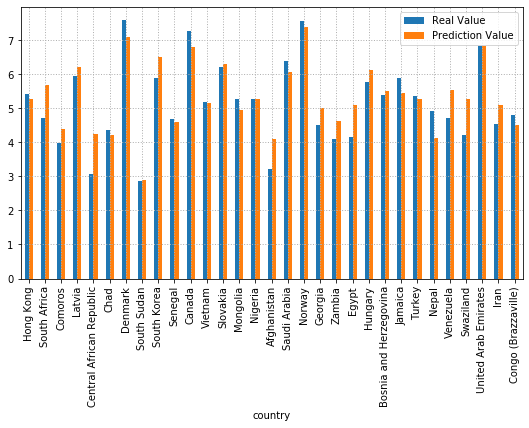

Intercept: 		 4.030352290870416
Root Mean Square Error:  0.5403140896052697
R^2 Value: 		 0.7936224568401856


In [586]:
y3_pred = happiness_model3.predict(X3_test)

checking_pred3 = pd.DataFrame({'Real Value': Y3_test, 'Prediction Value': y3_pred})
print(checking_pred3.head(8))


checking_pred3.plot(kind='bar', figsize=(9,5))
plt.grid(which='major', linestyle=':', linewidth='1')
plt.show()

rmse3 = np.sqrt(mean_squared_error(Y3_test, y3_pred))      
r2_value3 = r2_score(Y3_test, y3_pred)                     

print("Intercept: \t\t", happiness_model3.intercept_)
print("Root Mean Square Error: ", rmse3)
print("R^2 Value: \t\t", r2_value3)

In [573]:
vif_factor_3 = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
vif3 = pd.DataFrame(vif_factor_3, index = X3.columns, columns = ["VIF"])
print(vif3)

# we see that ""% of employed in services" and "mobile subscriptions %" have multicollinearity, but taking each of them 
# out reduces r-squared and increases rmse, so i'm leaving it in

                                                          VIF
Infant mortality rate (per 1000 live births          5.123977
Pop. using improved sanitation facilities (urba...   4.533146
Employment: Agriculture (% of employed)              5.120320
Employment: Services (% of employed)                13.411638
GDP per capita (current US$)                         4.594473
Population density (per km2, 2017)                   1.446299
GDP growth rate (annual %, const. 2005 prices)       1.397682
Refugees and others of concern to UNHCR (in tho...   1.299202
Health: Total expenditure (% of GDP)                 1.544092
Health: Physicians (per 1000 pop.)                   1.885931
Mobile-cellular subscriptions (per 100 inhabita...  15.658167
Individuals using the Internet (per 100 inhabit...   1.912535
CO2 emission estimates (million tons/tons per c...   1.362695
